In [1]:
import os
import gc
import cv2
import timm
import numpy as np
import pandas as pd
import itertools

import torch
from torch import nn
from torchvision import transforms
import torch.nn.functional as Func
import albumentations as A
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

In [2]:
text_data = pd.read_csv("../input/flickr-image-dataset/flickr30k_images/results.csv", delimiter="|")
text_data.columns = ["image", "caption_number", "caption"]
text_data["caption"] = text_data["caption"].str.lstrip()
text_data["caption_number"] = text_data["caption_number"].str.lstrip()
text_data.loc[19999, "caption_number"] = "4"
text_data.loc[19999, "caption"] = "A dog runs across the grass ."
ids = [id_ for id_ in range(len(text_data) // 5) for i in range(5)]
text_data["id"] = ids
text_data.to_csv("captions.csv", index = False)
text_data.head()

,image,caption_number,caption,id
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...,0
1,1000092795.jpg,1,"Two young , White males are outside near many ...",0
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,0
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,0
4,1000092795.jpg,4,Two friends enjoy time spent together .,0


In [3]:
class CFG:
    debug = False
    image_path = "../input/flickr-image-dataset/flickr30k_images/flickr30k_images"
    captions_path = "."
    batch_size = 16
    num_workers = 4
    learning_rate = 2e-3
    image_encoder_learning_rate = 2e-3
    text_encoder_learning_rate = 2e-3
    weight_decay = 3e-4
    patience = 0.5
    factor = 0.25
    epochs = 20
    device = "cuda"# if torch.cuda.is_available() else "cpu"
    model_name = "resnet50"
    image_embedding = 2048
    text_encoding_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 500
    pretrained = True
    trainable = True
    temperature = 1
    image_size = 224
    num_projection_layers = 6
    projection_dim = 256
    dropout = 0.25
    
CFG.device

In [6]:
class Utils:
    def __init__(self, name = "Metric"):
        self.name = name
        self.reset()
        
    def reset(self):
        self.avg, self.sum, self.count = [0] * 3
        
    def update(self, val, count = 1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count
        
    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text
    
def get_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        """
        
        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(list(captions), padding = True, truncation = True, max_length = CFG.max_length)
        self.transforms = transforms
        
    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }
        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image = image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]
        
        return item
    
    def __len__(self):
        return len(self.captions)
    
def get_transforms(mode = "train"):
    if mode == "train":
        return A.Compose([
            A.Resize(CFG.image_size, CFG.image_size, always_apply = True),
            A.Normalize(max_pixel_value = 255.0, always_apply = True),
        ])
    else:
        return A.Compose([
            A.Resize(CFG.image_size, CFG.image_size, always_apply = True),
            A.Normalize(max_pixel_value = 255.0, always_apply = True),
        ])

In [8]:
class ImageEncoder(nn.Module):
    """
    Convert Images to a fixed size vector
    """
    
    def __init__(self, model_name = CFG.model_name, pretrained = CFG.pretrained, trainable = CFG.trainable):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained, num_classes = 0, global_pool = "avg")
        for p in self.model.parameters():
            p.requires_grad = trainable
            
    def forward(self, x):
        return self.model(x)

In [9]:
class TextEncoder(nn.Module):
    def __init__(self,
                 model_name = CFG.text_encoding_model,
                 pretrained = CFG.pretrained,
                 trainable = CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config = DistilBertConfig())
            
        for p in self.model.parameters():
            p.required_grad = trainable
            
        self.target_token_index = 0
        
    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask = attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_index, :]

In [10]:
class ProjectionHead(nn.Module):
    def __init__(self,
                 embedding_dim,
                 projection_dim = CFG.projection_dim,
                 dropout = CFG.dropout):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
        
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [11]:
class CLIPModel(nn.Module):
    def __init__(self,
                 temperature = CFG.temperature,
                 image_embedding = CFG.image_embedding,
                 text_embedding = CFG.text_embedding):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim = image_embedding)
        self.text_projection = ProjectionHead(embedding_dim = text_embedding)
        self.temperature = temperature
        
    def forward(self, batch):
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(input_ids=batch["input_ids"], attention_mask = batch["attention_mask"])
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)
        
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        image_similarity = image_embeddings @ image_embeddings.T
        text_similarity = text_embeddings @ text_embeddings.T
        targets = Func.softmax((image_similarity + text_similarity) / 2 * self.temperature, dim =- 1)
        text_loss = cross_entropy(logits, targets, reduction = "none")
        image_loss = cross_entropy(logits.T, targets.T, reduction = "none")
        loss = (image_loss + text_loss) / 2.0
        return loss.mean()
    
def cross_entropy(predictions, targets, reduction = "none"):
        softmax_log = nn.LogSoftmax(dim =- 1)
        loss = (-targets * softmax_log(predictions)).sum(1)
        if reduction == "none":
            return loss
        elif reduction == "mean":
            return loss.mean()

In [12]:
batch_size = 4
dim = 256
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T
print(Func.softmax(out, dim =- 1))

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


In [13]:
def get_datasplits():
    dataframe = pd.read_csv(f"{CFG.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(7)
    validation_ids = np.random.choice(image_ids, size = int(0.25 * len(image_ids)), replace = False)
    training_ids = [id_ for id_ in image_ids if id_ not in validation_ids]
    training_dataframe = dataframe[dataframe["id"].isin(training_ids)].reset_index(drop = True)
    validation_dataframe = dataframe[dataframe["id"].isin(validation_ids)].reset_index(drop = True)
    return training_dataframe, validation_dataframe

def DataLoader(dataframe, tokenizer, mode):
    transforms = get_transforms(mode = mode)
    dataset = Dataset(dataframe["image"].values,
                      dataframe["caption"].values,
                      tokenizer = tokenizer,
                      transforms = transforms)
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size = CFG.batch_size,
                                             num_workers = CFG.num_workers,
                                             shuffle = True if mode == "train" else False)
    return dataloader

In [14]:
def training(model, training_loader, optimizer, lr_scheduler, step):
    loss_meter = Utils()
    tqdm_object = tqdm(training_loader, total = len(training_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()
            
        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)
        
        tqdm_object.set_postfix(train_loss = loss_meter.avg, lr = get_learning_rate(optimizer))
    return loss_meter


def validation(model, validation_loader):
    loss_meter = Utils()
    
    tqdm_object = tqdm(validation_loader, total = len(validation_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        
        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)
        
        tqdm_object.set_postfix(validation_loss = loss_meter.avg)
    return loss_meter


def main():
    train_dataframe, valid_dataframe = get_datasplits()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)    
    train_loader = DataLoader(train_dataframe, tokenizer, mode = "train")
    validation_loader = DataLoader(valid_dataframe, tokenizer, mode = "valid")
    
    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_learning_rate},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_learning_rate},
        {"params": itertools.chain(model.image_projection.parameters()),
         "lr": CFG.learning_rate, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay = 0.1)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min", patience = CFG.patience, factor = CFG.factor)
    step = "epoch"
    best_loss = float("inf")
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = training(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            validation_loss = validation(model, validation_loader)
            
        if validation_loss.avg < best_loss:
            best_loss = validation_loss.avg
            torch.save(model.state_dict(), "CLIPModel.pt")
            print("Best Model Saved")
            
        lr_scheduler.step(validation_loss.avg)

In [15]:
%%time
#main()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [16]:
#"../input/clipweight/CLIPModel.pt"

'../input/clipweight/CLIPModel.pt'

In [17]:
def get_image_embeddings(validation_dataframe, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    validation_loader = DataLoader(validation_dataframe, tokenizer, mode = "valid")
    
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location = CFG.device))
    model.eval()
    
    validation_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(validation_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            validation_image_embeddings.append(image_embeddings)
    return model, torch.cat(validation_image_embeddings)

In [18]:
_, validation_dataframe = get_datasplits()
model, image_embeddings = get_image_embeddings(validation_dataframe, "../input/clipweight/CLIPModel.pt")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

  0%|          | 0/2483 [00:00<?, ?it/s]

In [19]:
def generate_matches(model, image_embeddings, query, image_filenames, n = 9):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {key: torch.tensor(values).to(CFG.device)
             for key, values in encoded_query.items()}
    with torch.no_grad():
        text_features = model.text_encoder(input_ids = batch["input_ids"], attention_mask = batch["attention_mask"])
        text_embeddings = model.text_projection(text_features)
    image_embeddings_n = Func.normalize(image_embeddings, p = 5, dim =- 1)
    text_embeddings_n = Func.normalize(text_embeddings, p = 5, dim =- 1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]
    
    _, axes = plt.subplots(3, 3, figsize = (10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
        
    plt.show()

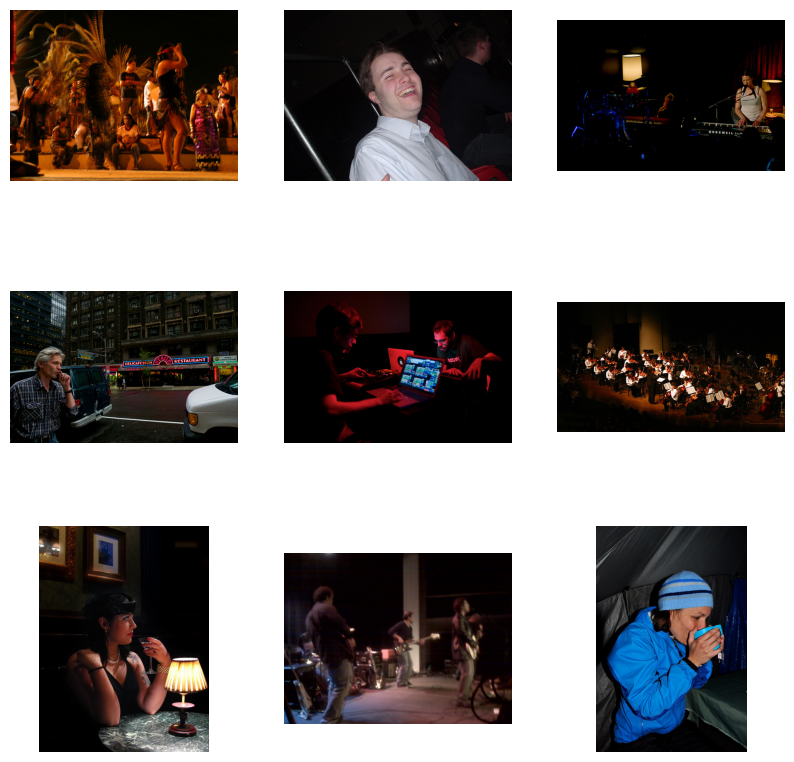

In [22]:
generate_matches(model,
                 image_embeddings,
                 query = "tortoise in the sea",
                 image_filenames = validation_dataframe["image"].values,
                 n = 9)